In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**모델 훈련**

선형 모델을 훈련시키는 두 가지 방법
* 직접 계산할 수 있는 공식을 사용하여 훈련셋에 가장 잘 맞는 모델 파라미터(즉, 훈련셋에 대해 비용 함수를 최소화하는 모델 파라미터)를 해석적으로 구한다.

* 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용함수를 훈련셋에 대해 최소화 시킨다. 결국에는 앞의 방법과 동일한 파라미터로 수렴한다.
<br>나중에는 경사하강법의 변종으로 배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법(SGD)도 살펴보겠다.


그 다음에는 비선형 데이터셋에 훈련시킬 수 있는 조금 더 복잡한 모델인 다항 회귀를 살펴보겠다.
<br>이 모델은 선형 회귀보다 파라미터가 많아서 훈련 데이터에 과대적합되기 더 쉽다.
<br>따라서 학습 곡선(learning curve)을 사용해 모델이 과대적합되는지 감지하는 방법도 살펴보겠다.
<br>그런 다음 훈련셋의 과대적합을 감소시킬 수 있는 규제 기법을 몇 가지 알아보겠다.

마지막으로 분류 작업에 널리 사용하는 모델인 로지스틱 회귀와 소프트맥스 회귀를 살펴보겠다.

## 1. 선형 회귀

---
**1. 정규 방정식을 사용한 선형 회귀**

비용함수를 최소화하는 theta값을 찾기 위한 해석적인 방법이 있다. 
<br>다른 말로 하면 바로 결과를 얻을 수 있는 수학 공식이 있다. 이를 정규 방정식이라고 한다.(normal equation)

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

* theta hat은 비용함수를 최소화하는 theta값이다.
* y는 y^(1) 부터  y^(m) 까지 포함하는 타겟 벡터이다. 


이 공식을 테스트하기 위해 선형처럼 보이는 데이터를 생성하겠다.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_plot


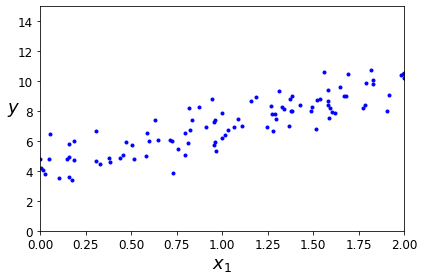

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
# 그럼 이제 정규 방정식을 사용해 theta hat을 계산해 보겠다.
# inv()를 사용해 역행렬을 계산하고 dot()를 사용해 행렬 곱셈을 하겠다.
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가한다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

이 데이터를 생성하기 위해 사용한 함수는 y = 4 + 3x1 + 가우시안 잡음이다.
<br>정규 방정식으로 계산한 값을 확인해 보겠다.

In [5]:
theta_best

array([[4.18493584],
       [2.87153157]])

theta0 = 4.184와 theta1 = 2.871 대신 theta0 = 4 와 theta1 = 3을 기대했었다.
<br>매우 비슷하지만 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못했다.

theta hat을 사용해 예측을 해보겠다.

$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.18493584],
       [9.92799897]])

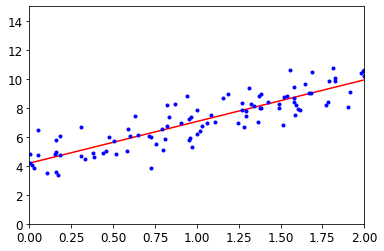

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

그림 저장: linear_model_predictions_plot


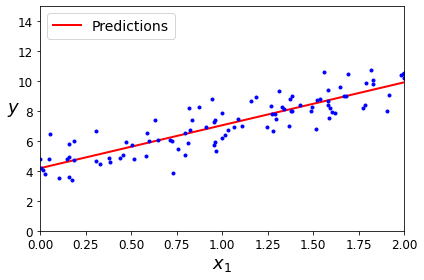

In [8]:
# 책에 있는 그림은 범례와 축 레이블이 있는 그래프이다:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

사이킷런에서 선형 회귀를 수행하는 것은 간단하다.
<br>(사이킷런에서는 특성의 가중치(coef_)와 편향(intercept_)을 분리하여 저장한다.)

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.18493584]), array([[2.87153157]]))

In [10]:
lin_reg.predict(X_new)

array([[4.18493584],
       [9.92799897]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있다

In [11]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.18493584],
       [2.87153157]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산한다. 
<br>$\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)이다(Moore–Penrose 유사역행렬이다). 
<br>`np.linalg.pinv()`을 사용해서 유사역행렬을 직접 계산할 수 있다:


$\boldsymbol{\hat{\theta}} = \mathbf{X}^{-1}\hat{y}$

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.18493584],
       [2.87153157]])

## 2. 경사 하강법

GD는 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘이다.
<br>기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것이다.

---
**1. 배치 경사 하강법을 이용한 선형 회귀**

**식 4-6: 비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

위 공식은 매 경사 하강법 스텝에서 전체 훈련 셋 X에 대해 계산한다.
<br> 그래서 이 알고리즘을 배치 경사 하강법 이라고 한다.
<br>즉, 매 스텝에서 훈련 데이터 전체를 사용한다.(사실 전체 경사 하강법이 더 적절한 이름 같다.)
<br>이런 이유로 매우 큰 훈련셋에서는 아주 느리다.
<br>그러나 경사 하강법은 특성 수에 민감하지 않다.
<br>수십만 개의 특성에서 선형 회귀를 훈련시키려면 정규방정식이나 SVD 분해보다 경사 하강법을 사용한 편이 훨씬 빠르다.

<br><br>

**식 4-7: 경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

이 알고리즘을 간단히 구현해 보겠다.

In [13]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
# 계산된 theta를 확인해보자.
theta

array([[4.18493584],
       [2.87153157]])

In [15]:
X_new_b.dot(theta)

array([[4.18493584],
       [9.92799897]])

정규 방정식으로 찾은 것과 정확히 같다. 경사 하강법이 완벽하게 작동하였다.
<br>학습률을 바꿔보면 어떨까?
<br>아래 그림은 세 가지 다른 학습률을 사용하여 진행한 경사 하강법의 스텝 처음 10개를 보여준다.

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


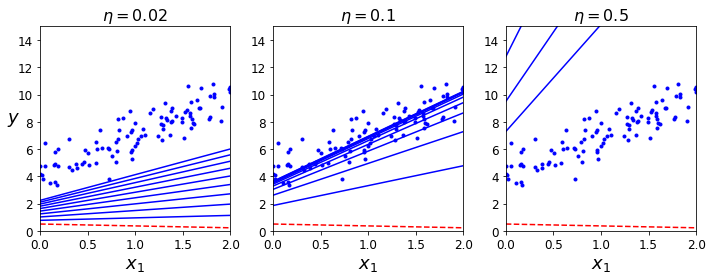

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

왼쪽은 학습률이 너무 낮다. 알고리즘은 최적점에 도달하겠지만 시간이 오래 걸릴 것이다.
<br>가운데는 학습률이 아주 적당해 보인다. 반복 몇 번 만에 이미 최적점에 수렴했다.
<br>오른쪽은 학습률이 너무 높다. 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 점점 더 멀어져 발산한다.


적절한 학습률을 찾으려면 그리드 탐색을 사용한다.
<br>하지만 그리드 탐색에서 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 한다.

---
**2. 확률적 경사 하강법**

배치 경사 하강법의 가장 큰 문제는 매 스텝에서 전체 훈련셋을 사용해 그래디언트를 계산한다는 사실이다.
<br>훈련 셋이 커지면 매우 느려지게 된다.
<br>이와는 정반대로 확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그래디언트를 계산한다.
<br>매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 확실히 훨씬 빠르다.
<br>또한 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련셋도 훈련시킬 수 있다.
<br>(SGD는 외부 메모리 학습 알고리즘으로 구현할 수 있다.)


반면 확률적(즉, 무작위)이므로 이 알고리즘은 배치 경사 알고리즘보다 훨씬 불안정하다.
<br>비용함수가 최소값에 다다를 때까지 부드럽게 감소하지 않고 위 아래로 요동치며 평균적으로 감소한다.
<br>시간이 지나면 최소값에 매우 근접하겠지만 요동이 지속되면서 최소값에 안착하지 못할 것이다.
<br>알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아니다.


비용 함수가 매우 불규칙할 때 알고리즘이 지역 최소값을 건너 뛰도록 도와주므로 확률적 경사 하강법이 배치 경사 하강법보다 전역 최소값을 찾을 가능성이 높다.


무작위성은 지역 최소값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최소값에 다다르지 못하게 한다는 점에서는 좋지 않다.
<br>이 딜레마를 해결하는 한 가지 방법은 학습률을 점진적으로 감소시키는 것이다.
<br>시작할 때는 학습률을 크게 하고(수렴을 빠르게 하고 지역 최소값에 빠지지 않게 한다.) 점차 작게 줄여서 알고리즘이 전역 최소값에 도달하게 한다.
<br>이 과정은 금속공학 분야에서 가열한 금속을 천천히 냉각시키는 어닐링(annealing, 풀림)과정에서 영감을 얻은 담금질 기법(simulated annealing)알고리즘과 유사하다.
<br>매 반복에서 학습률을 결정하는 함수를 학습 스케줄(또는 학습률 스케줄)이라고 부른다.
<br>학습률이 너무 빨리 줄어들면 지역 최소값에 갇히거나 최소값까지 가는 중간에 멈춰버릴 수도 있다.
<br>학습률이 너무 천천히 줄어들면 오랫동안 최소값 주변을 맴돌거나 훈련을 너무 일찍 중지해서 지역 최소값에 머무를 수 있다.


다음 코드는 간단한 학습 스케줄을 사용한 확률적 경사 하강법의 구현이다.

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


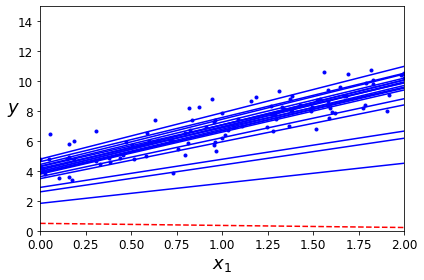

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 책에는 없음
            y_predict = X_new_b.dot(theta)           # 책에는 없음
            style = "b-" if i > 0 else "r--"         # 책에는 없음
            plt.plot(X_new, y_predict, style)        # 책에는 없음
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # 책에는 없음

plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
save_fig("sgd_plot")                                 # 책에는 없음
plt.show()                                           # 책에는 없음

일반적으로 한 반복에서 m번(m은 훈련셋에 있는 샘플 수이다.) 되풀이 되고, 이때 각 반복을 에포크 라고 한다.
<br>배치 경사 하강법 코드가 전체 훈련셋에 대해 1,000번 반복하는 동안 이 코드는 훈련셋에서 50번만 반복하고도 매우 좋은 값에 도달했다.


위 그림은 훈련 스텝의 첫 20개를 보여준다.(스텝이 불규칙하게 진행한다.)

In [20]:
theta

array([[4.19327541],
       [2.86064586]])

샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있다.
<br>알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련셋을 섞은 후 (입력 특성과 레이블을 동일하게 섞어야 한다.) 
<br>차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법을 사용할 수 있다.(사이킷런의 SGDClassifier와 SGDRegressor가 사용하는 방법이다.)
<br>그러나 이렇게 하면 보통 더 늦게 수렴된다.


사이킷런에서 SGD방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor클래스를 사용한다.
<br>다음 코드는 최대 1,000번 에포크 동안 실행된다(max_iter=1000)
<br>또는 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행된다.(tol=1e-3)
<br>학습률 0.1(eta0=0.1)로 기본 학습 스케줄을 사용한다.
<br>규제는 전혀 사용하지 않았다.(penalty=None)

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [22]:
# 여기에서도 정규방정식으로 구한 것과 매우 비슷한 값을 얻었다.
sgd_reg.intercept_, sgd_reg.coef_

(array([4.17548608]), array([2.86942429]))

---
**3. 미니배치 경사 하강법**

각 스텝에서 전체 훈련 세트(배치 경사 하강법에서처럼)나 하나의 샘플(확률적 경사 하강법에서처럼)을 기반으로 그래디언트를 계산하는 것이 아니라 미니배치라고 부르는 임의의 작은 샘플 세트에 대해 그래디언트를 계산한다.
<br>확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상이다.


특히 미니배치를 어느 정도 크게 하면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직인다.
<br>결국 미니배치 경사 하강법이 SGD보다 최소값에 더 가까이 도달하게 될 것이다.
<br>하지만 지역 최소값에서 빠져 나오기는 더 힘들지도 모른다.(선형회귀와 같지 않고 지역 최소값이 문제가 되는 경우)

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.22962554],
       [2.90302559]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


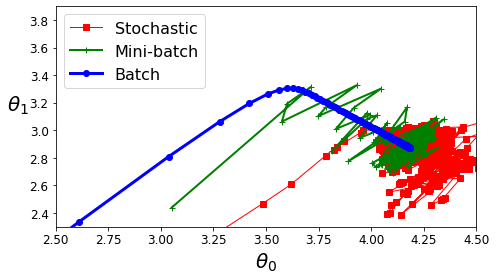

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

위의 그림에서 모두 최소값 근처에 도달했지만 배치 경사 하강법의 경로가 실제로 최소값에서 멈춘 반면
<br>확률적 경사 하강법과 미니 배치 경사하강법은 근처에서 맴돌고 있다.
<br>그렇지만 배치 경사 하강법에는 매 스텝에서 많은 시간이 소요되고, 확률적 경사하강법과 미니배치 경사하강법도 적절한 학습 스케줄을 사용하면 최소값에 도달한다는 것을 잊지 말아야 한다.

---
**3. 다항 회귀**

가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면 어떨까?
<br>신기하게도 비선형 데이터를 학습하는 데 선형 모델을 사용할 수 있다.
<br>이렇게 하는 간단한 방법은 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형모델을 훈련시키는 것이다.
<br>이런 기법을 다항 회귀(polynomial regression)라고 한다.


예를 들어 보겠다. 먼저 간단한 2차 방정식(y = ax<sup>2</sup> + bx + c)으로 비선형 데이터를 생성하겠다.(약간의 잡음을 포함한다.)

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


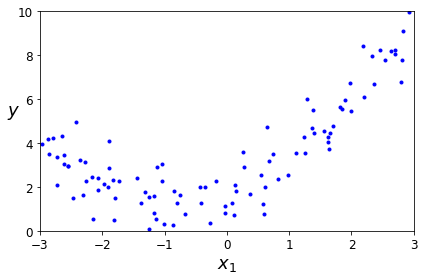

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

확실히 직선은 이 데이터에 잘 맞지 않을 것이다. 그러므로 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터를 변환해보겠다.
<br>훈련 세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가한다.(여기서는 특성 하나가 추가된다.)

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함한다. 이 확장된 훈련데이터에 LinearRegression을 적용해 보겠다.

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


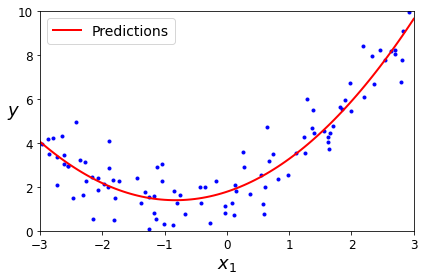

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

나쁘지 않다. 실제 원래 함수가 y = 0.5x<sub>1</sub><sup>2</sup> + 1.0x<sub>1</sub> + 2.0 + 가우시안 잡음이고 
<br>예측된 모델은 y_hat = 0.56x<sub>1</sub><sup>2</sup> + 0.93x<sub>1</sub> + 1.78 이다.


특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있다.(일반적인 선형 회귀 모델에서는 하지 못한다.)
<br>PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문이다.
<br>예를 들어 두 개의 특성 a, b가 있을 때 degree = 3으로 PolynomialFeatures를 적용하면 a<sup>2</sup>, a<sup>3</sup>, b<sup>2</sup>, b<sup>3</sup> 뿐만 아니라
<br>ab, a<sup>2</sup>b, ab<sup>2</sup> 도 특성으로 추가한다.

---
**4. 학습 곡선**

고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것이다.
<br>예를 들어 아래 그림은 300차 다항 회귀 모델을 이전의 훈련 데이터에 적용한 것이다. 
<br>단순한 선형 모델이나 2차 모델(2차 다항 회귀 모델)과 결과를 비교해 보라. 
<br>300차항 회귀 모델은 훈련 샘플에 가능한 한 가까이 가려고 구불구불하게 나타난다.

그림 저장: high_degree_polynomials_plot


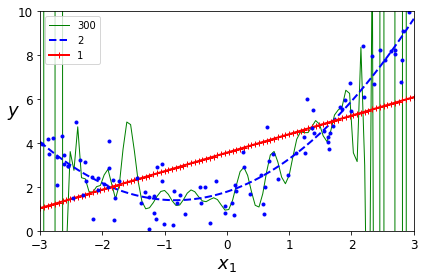

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

이 고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대적합되었다. 반면에 선형 모델은 과소 적합이다.
<br>이 경우 가장 일반화가 잘될 모델은 2차 다항 회귀이다.
<br>이차 방정식으로 생성한 데이터이기 때문에 당연한 결과지만 일반적으로는 어떤 함수로 데이터가 생성되었는지 알 수 없다.
<br>그러면 얼마나 복잡한 모델을 사용할지 어떻게 결정할 수 있을까? 어떻게 모델이 데이터에 과대적합 또는 과소적합되었는지 알 수 있을까?


2장에서 모델의 일반화 성능을 추정하기 위해 교차 검증을 사용했다.
<br>훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘다면 모델이 과대적합된 것이다.
<br>만약 양쪽에 모두 좋지 않으면 과소적합이다. 이 때 모델이 너무 단순하거나 복잡하다고 말한다.


또 다른 방법은 학습 곡선을 살펴보는 것이다.
<br>이 그래프는 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타낸다.
<br>이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 된다.
<br>아래 코드는 훈련 데이터에서 모델의 학습 곡선을 그리는 함수를 정의한다.

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

그림 저장: underfitting_learning_curves_plot


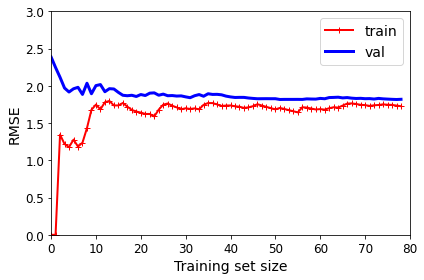

In [36]:
# 단순 선형 회귀 모델(직선)의 학습 곡선을 살펴보자.
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
save_fig("underfitting_learning_curves_plot")   # 책에는 없음
plt.show()                                      # 책에는 없음

과소적합된 위 모델은 조금 설명이 필요하다. 먼저 훈련 데이터의 성능을 보겠다.
<br>그래프가 0에서 시작하므로 훈련 세트에 하나 혹은 두 개의 샘플이 있을 땐 모델이 완벽하게 작동한다.
<br>하지만 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해 진다.
<br>그래서 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승한다.
<br>이 위치에서는 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않는다.
<br>그럼 이제 검증 데이터에 대한 모델의 성능을 보겠다.
<br>모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 검증 오차가 초기에 매우 크다.
<br>모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소한다.
<br>하지만 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워진다.


이 학습 곡선이 과소적합 모델의 전형적인 모습이다.
<br>두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있다.
<br>(모델이 훈련 데이터에 과소적합되어 있다면 훈련 샘플을 더 추가해도 효과가 없다. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다.)

그림 저장: learning_curves_plot


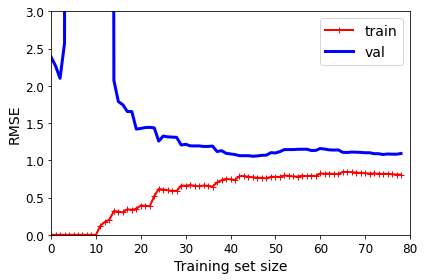

In [38]:
# 이제 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선을 그려보겠다.
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음

이 학습곡선은 이전과 비슷해 보이지만 두 가지 매우 중요한 차이점이 있다.

* 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다.
* 두 곡선 사이에 공간이 있다. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 이는 과대적합 모델의 특징이다. 그러나 더 큰 훈련 셋을 사용하면 두 곡선이 점점 가까워진다.
<br>(과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것이다.)

---
**편향 / 분산 트레이드 오프**

통계학과 머신러닝에서 나온 중요한 이론 하나는 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있다는 사실이다.

* 편향
    <br>일반화 오차 중에서 편향은 잘못된 가정으로 인한 것이다.
    <br>예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우이다. 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉽다
    <br>(여기서 편향을 선형 모델의 편향과 혼동하지 말라. bias란 용어가 주로 사용되는 곳이 크게 편향/분산 트레이드오프, 선형 모델의 상수항, 신경망 모델의 상수항이다. 여기서는 선형 모델과 신경망 모델을 설명할 때 혼동을 피하기 위해 절편이란 용어 대신 모두 편향이라고 하였다. 편향/분산 트레이드오프에서의 편향은 항상 분산과 동시에 등장하므로 쉽게 구별할 수 있다.)
    
 
* 분산
     <br>분산(variance)은 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다. 
     <br>자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다.
     
     
     
* 줄일 수 없는 오차
    <br>irreducible error는 데이터 자체에 있는 잡음 때문에 발생한다.
    <br>이 오차를 출일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것이다.
    <br>(예를 들어 고장 난 센서 같은 데이터 소스를 고치거나 이상치를 감지해 제거한다.)
    
    
모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어든다.
<br>반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아진다. 그래서 트레이드오프라고 부른다.

## 5. 규제가 있는 선형 모델

과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것이다.(즉, 모델을 제한한다)
<br>자유도를 줄이면 데이터에 과대적합되기 더 어려워진다.
<br>다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것이다.


선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다.
<br>각기 다른 방법으로 가중치를 제한하는 '릿지'회귀, '라쏘'회귀, 엘라스틱넷을 살펴보겠다.

---
**1. 릿지 회귀**


릿지 회귀(또는 티호노프(Tikhonov)규제)는 규제가 추가된 선형 회귀 버전이다.
<br>규제항 $ \alpha \sum\limits_{i=1}^{n}{\theta_i}^2 $ 이 비용 함수에 추가된다.
<br>이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력한다.
<br>규제항은 훈련하는 동안에만 비용 함수에 추가된다.
<br>모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가한다.


하이퍼 파라미터  $ \alpha $는 모델을 얼마나 많이 규제할지 조절한다.
<br>$ \alpha $ = 0이면 릿지 회귀는 선형 회귀와 같아진다.
<br>$ \alpha $가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다.


릿지 회귀의 비용 함수
<br>
$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

In [43]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

그림 저장: ridge_regression_plot


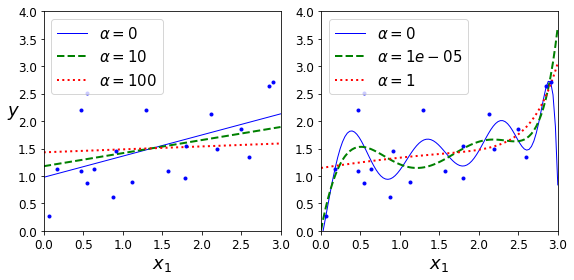

In [44]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

왼쪽 그래프는 평범한 릿지 모델을 사용해 선형적인 예측을 만들었다.
<br>오른쪽 그래프는 PolynomialFeatures(degree=10)을 사용해 먼저 데이터를 확장하고 StandardScaler를 사용해 스케일을 조정한 후 릿지 모델을 적용했다.
<br>결국 이는 릿지 규제를 사용한 다항 회귀가 된다.
<br>$ \alpha $를 증가 시킬수록 직선에 가까워지는 것을 볼 수 있다. 즉, 모델의 분산은 줄지만 편향은 커지게 된다.


선형 회귀와 마찬가지로 릿지 회귀를 계산하기 위해 정규방정식을 사용할 수도 있고 경사 하강법을 사용할 수도 있다.
<br>장단점은 이전과 같다.



다음은 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예이다.
<br>(안드레 루이 숄레스키가 발견한 행렬 분해(matrix factorization)를 사용하여 릿지회귀의 정규방정식을 변형한 방정식을 사용한다.)

In [45]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [46]:
# 다음은 확률적 경사 하강법을 사용했을 때이다.
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.46543286])

In [48]:
#향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.21 버전의 기본값인 max_iter=1000과 tol=1e-3으로 지정한다.
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

대안으로 Ridge에 solver="sag"를 사용할 수 있다. 
<br>확률적 평균 경사 하강법(stochastic average gradient descent)은 SGD의 변종이다.
<br>sag는 확률적 경사 하강법과 거의 비슷하지만 현재 그래디언트와 이전 스텝에서 구한 모든 그래디언트를 합해서 평균한 값으로 모델 파라미터를 갱신한다. 사이킷런 0.19버전에서는 sag의 개량버전인 saga 알고리즘이 추가되었다.

In [47]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

---
**2. 라쏘 회귀**

릿지 회귀처럼 비용 함수에 규제항을 더하지만 l2 norm의 제곱을 2로 나눈 것 대신 가중치 벡터의 l1 norm을 사용한다.


라쏘 회귀의 비용 함수
<br>
$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$


아래 그래프는 위의 그래프와 같지만 릿지 모델 대신 라쏘 모델과 조금 더 작은 알파값을 사용했다.

C:\Users\acorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


그림 저장: lasso_regression_plot


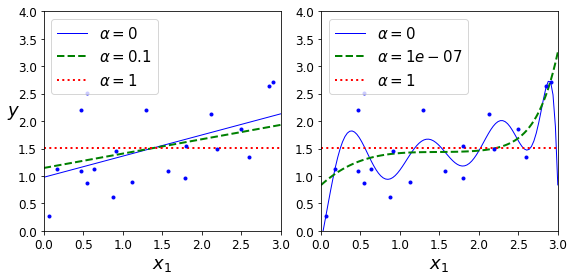

In [49]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점이다.(즉, 가중치가 0이 된다)
<br>예를 들어 오른쪽 그래프에서 점선($ \alpha $ = 10<sup>-7</sup>)은 2차 방정식처럼 보이며 거의 선형적이다.
<br>차수가 높은 다항 특성의 가중치가 모두 0이 되었다.
<br>다시 말해 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델(sparse model)을 만든다.(즉, 0이 아닌 특성의 가중치가 적다)


아래 그림을 보면 쉽게 이해할 수 있다.
<br>두 축은 모델 파라미터 두 개를 나타내고 배경의 등고선은 각기 다른 손실 함수를 나타낸다.
<br>왼쪽 위 그래프의 등고선은 l1 손실(|${\theta}$<sub>1</sub>| + |${\theta}$<sub>2</sub>|) 을 나타낸다.
<br>축에 가까워지면서 선형적으로 줄어든다.
<br>예를 들어 모델 파라미터를 ${\theta}$<sub>1</sub> = 2, ${\theta}$<sub>2</sub> = 0.5 로 초기화하고 경사 하강법을 실행하면 두 파라미터가 동일하게 감소될 것이다.(노란 점선)
<br>따라서 ${\theta}$<sub>2</sub> 가 먼저 0에 도달한다.( ${\theta}$<sub>2</sub> 가 시작할 때 0에 더 가깝기 때문이다.)
<br>그 다음 경사 하강법이  ${\theta}$<sub>1</sub> = 0 에 도달할 때까지 축을 따라 내려갔다.
<br>(l1의 그래디언트는 0에서 정의되지 않기 때문에 진동이 조금 있다. 이 지점에서 그래디언트는 -1 또는 1이다.)
<br>오른쪽 위 그래프의 등고선은 라쏘 손실 함수를 나타낸다.(즉, l1 손실을 더한 MSE 손실함수)
<br>하얀 작은 원이 경사 하강법이  ${\theta}$<sub>1</sub> = 0.25, ${\theta}$<sub>2</sub> = -1 로 초기화 된 모델 파라미터를 최적화하는 과정을 보여준다.
<br>여기서도 ${\theta}$<sub>2</sub> = 0 으로 빠르게 줄어들고 그다음 축을 따라 진동하면서 전역 최적점(빨간 사각형)에 도달한다.
<br>${\alpha}$ 를 증가하면 전역 최적점이 노란 점선을 따라 왼쪽으로 이동한다.
<br>${\alpha}$ 를 감소하면 전역 최적점이 오른쪽으로 이동한다.
<br>(이 예에서 규제가 없는 MSE의 최적 파라미터는 ${\theta}$<sub>1</sub> = 2, ${\theta}$<sub>2</sub> = 0.5 이다.)

In [51]:
import matplotlib.pyplot as plt
import numpy as np

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


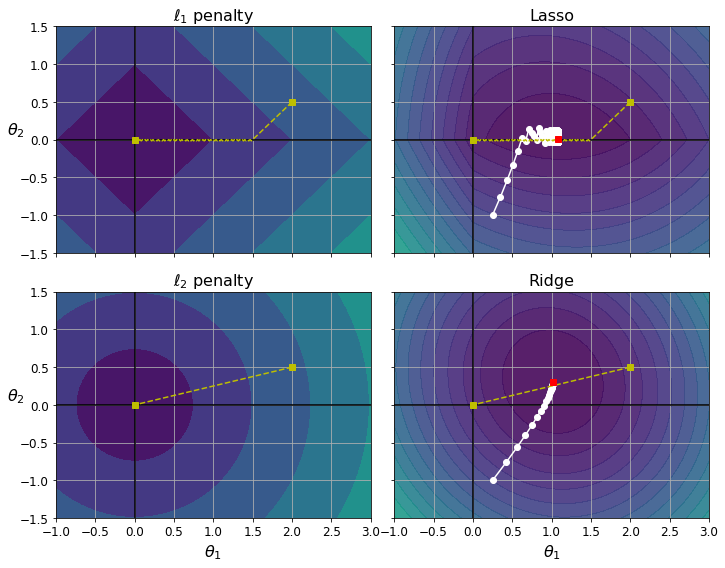

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

아래 두 개의 그래프도 동일하지만 l2 패널티를 사용한다.
<br>왼쪽 아래 그래프에서 l2 손실은 원점에 가까울수록 줄어드는 것을 볼 수 있다.
<br>따라서 경사 하강법이 원점까지 직선 경로를 따라 간다.
<br>오른쪽 아래 그래프의 등고선은 릿지 회귀의 비용 함수를 나타낸다.(즉, l2 손실을 더한 MSE 손실 함수)
<br>라쏘와 다른 점은 크게 두 가지이다.
<br>첫째 파라미터가 전역 최적점에 가까워질수록 그래디언트가 작아진다.
<br>따라서 경사 하강법이 자동으로 느려지고 수렴에 도움이 된다.(진동이 없다.)
<br>둘째 알파를 증가시킬수록 최적의 파라미터(빨간 사각형)가 원점에 더 가까워진다. 하지만 완전히 0이 되지는 않는다.


다음은 Lasso 클래스를 사용한 간단한 사이킷런 예제이다.

In [53]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

---
**3. 엘라스틱넷**

릿지회귀와 라쏘회귀를 절충한 모델이다.
<br>규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 정도는 혼합 비율 r을 사용해 조정한다.
<br>r=0 이면 엘라스틱넷은 릿지 회귀와 같고, r=1이면 라쏘 회귀와 같다.


엘라스틱넷 비용 함수
<br>
$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$


그럼 보통의 선형 회귀(즉, 규제가 없는 모델), 릿지, 라쏘, 엘라스틱넷을 언제 사용해야 할까?
<br>적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 한다.
<br>릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다.
<br>이 모델들은 이전에 이야기한 것처럼 불필요한 특성의 가중치를 0으로 만들어준다.
<br>특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호한다.
<br>(라쏘는 특성 수가 샘플 수(n)보다 많으면 최대 n개의 특성을 선택한다. 또한 여러 특성이 강하게 연관되어 있으면 이들 중 임의의 특성 하나를 선택한다.)


다음은 사이킷런의 ElasticNet을 사용한 간단한 예제이다.(l1_ratio가 혼합 비율 r이다.)

In [54]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

---
**4. 조기 종료**

경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 아주 색다른 방식은 검증 에러가 최소값에 도달하면 바로 훈련을 중지시키는 것이다. 이를 조기 종료(early stopping)라고 한다.
<br>아래 그래프는 배치 경사 하강법으로 훈련시킨 복잡한 모델(고차원 다항 회귀 모델)을 보여준다.
<br>에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련세트에 대한 예측 에러(RMSE)와 검증 셋트에 대한 예측 에러가 줄어든다.
<br>그러나 잠시 후 감소하던 검증 에러가 멈추었다가 다시 상승한다. 모델이 훈련 데이터에 과대적합되기 시작하는 것을 의미한다.
<br>조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는 것이다.
<br>이 규제 테크닉은 매우 효과적이고 간단해서 제프리 힌턴이 '훌륭한 공짜점심(beautiful free lunch)'이라고 불렀다.

In [57]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [58]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그림 저장: early_stopping_plot


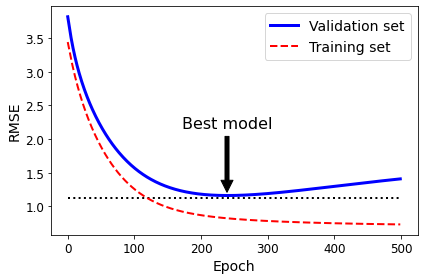

In [59]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [60]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

확률적 경사하강법이나 미니배치 경사하강법에서는 곡선이 그리 매끄럽지 않아 최소값에 도달했는지 확인하기 어려울 수 있다.
<br>한 가지 해결책은 검증 에러가 일정 시간 동안 최소값보다 클 때(모델이 더 나아지지 않는다고 확신이 들 때) 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것이다.



위의 코드에서 warm_start = True로 지정하면 fit()가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다.

## 6. 로지스틱 회귀